In [1]:
%load_ext lab_black


from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.io import wavfile
from sklearn import tree
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import serial
import sys


In [2]:
BASE_PATH = os.path.join("/tf/notebooks/CEIA/ia-embebida/tp-final")
DATASET_PATH = os.path.join(BASE_PATH, "assets/audios")
ANNOTATIONS_FILE = os.path.join(BASE_PATH, "assets/train_labels.csv")


def load_dataset(data_path, annotations_file):
    df = pd.read_csv(annotations_file)
    data = []
    for filename_id in df["filename"]:
        filename = f"{str(filename_id).zfill(4)}.wav"
        audio_file = os.path.join(DATASET_PATH, filename)
        _, audio = wavfile.read(audio_file)
        data.append(audio.astype(float))
    return data, df["label"].to_numpy()


data, labels = load_dataset(DATASET_PATH, ANNOTATIONS_FILE)

In [3]:
max_val = 32767
min_val = -32768
samplerate = 22050

data_scaled = [(event - min_val) / (max_val - min_val) - 0.5 for event in data]

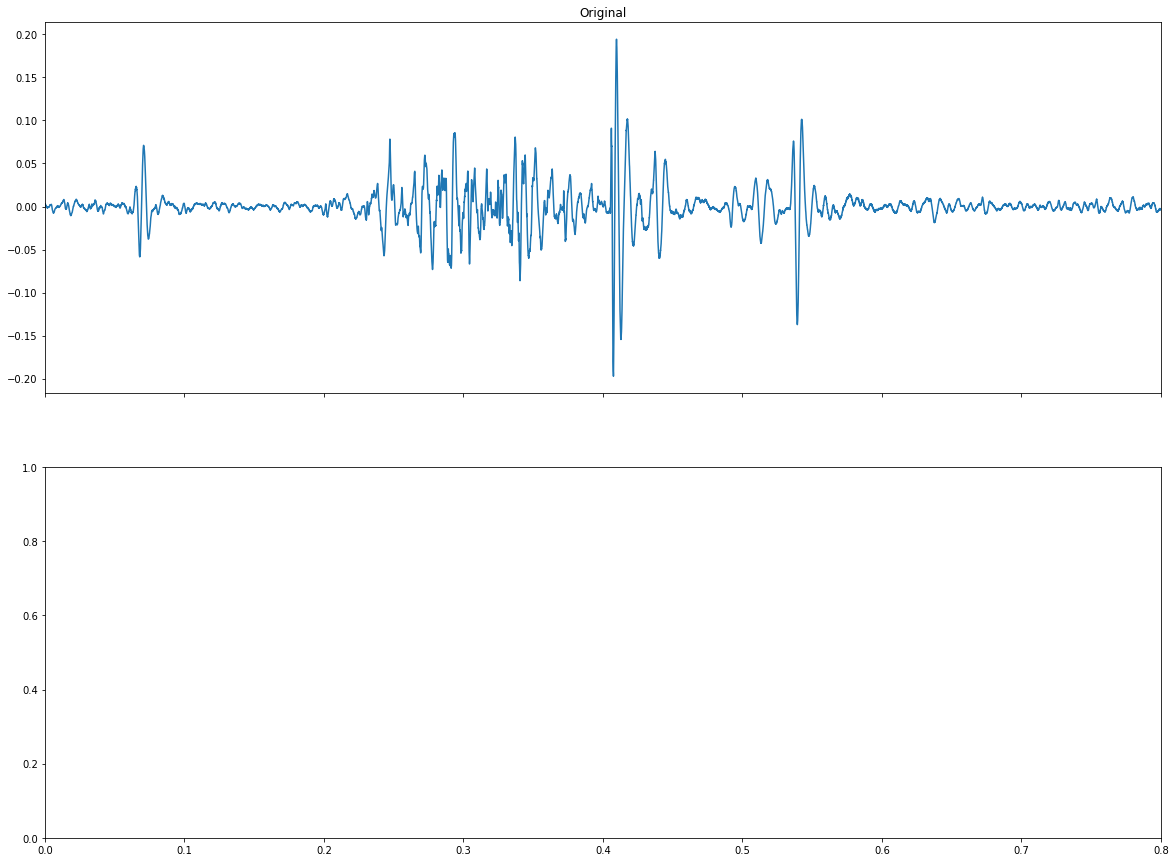

In [4]:
sample_event = data_scaled[2]
event_duration = len(sample_event) / samplerate
timeline = np.linspace(0, event_duration, num=len(sample_event))

f, axes = plt.subplots(2, sharex=True, figsize=(20, 15))

axes[0].plot(timeline, sample_event)
axes[0].set_xlim([0, event_duration])
axes[0].set_title("Original")

f.show()

In [5]:
events_abs = [np.abs(event) for event in data_scaled]

cutoff_freq = 5  # Hz
sos_butter = signal.butter(2, cutoff_freq, "lowpass", output="sos", fs=samplerate)
events_envelope = [
    signal.sosfiltfilt(sos_butter, event, axis=0) for event in events_abs
]

In [6]:
events_dec = [event[::10] for event in events_envelope]

samplerate_dec = samplerate / 10

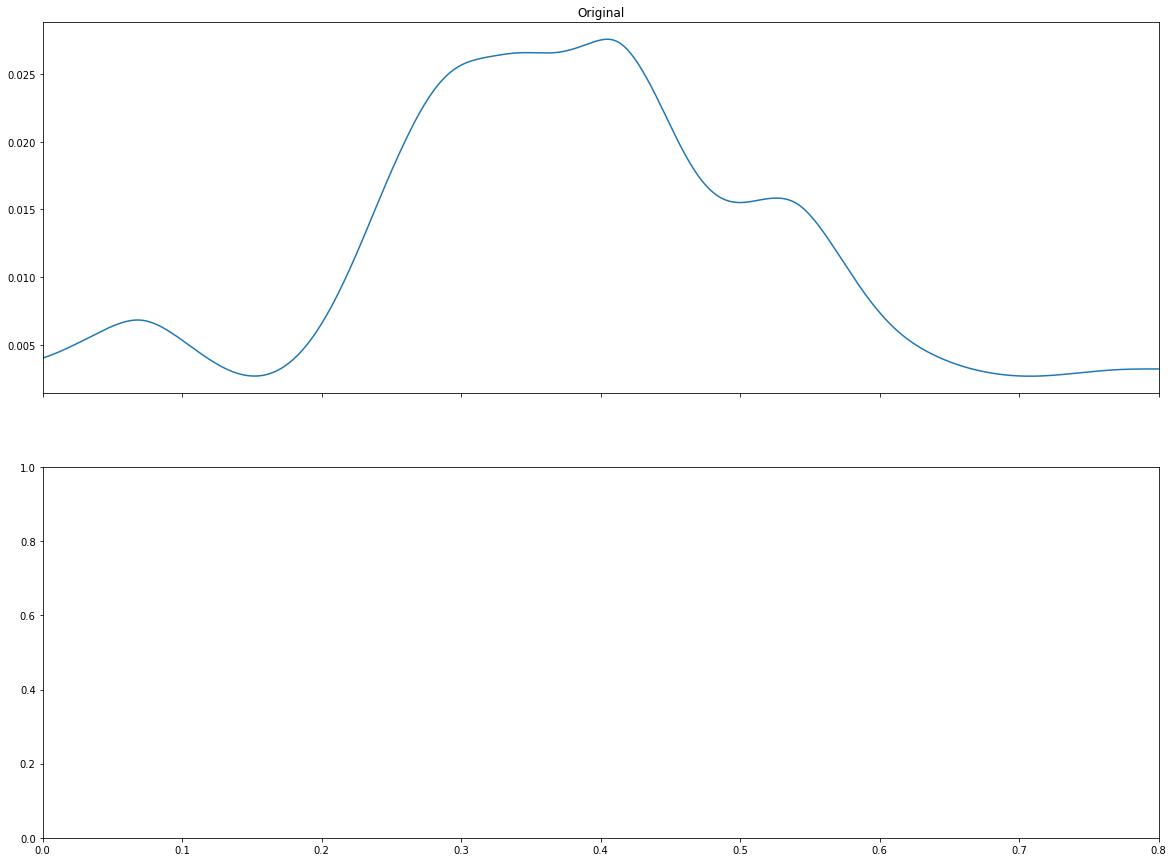

In [7]:
sample_event = events_dec[2]
event_duration = len(sample_event) / samplerate_dec
timeline = np.linspace(0, event_duration, num=len(sample_event))

f, axes = plt.subplots(2, sharex=True, figsize=(20, 15))

axes[0].plot(timeline, sample_event)
axes[0].set_xlim([0, event_duration])
axes[0].set_title("Original")

f.show()

In [8]:
threshold = 0.010

events_above_thres = [event >= threshold for event in events_dec]

envelope_slope_sign = []
signal_duration = []
for event, above_thres in zip(events_dec, events_above_thres):
    envelope_slope_sign.append(np.sign(np.diff(event, append=0)) * above_thres)
    signal_duration.append(np.ones_like(event) * above_thres)

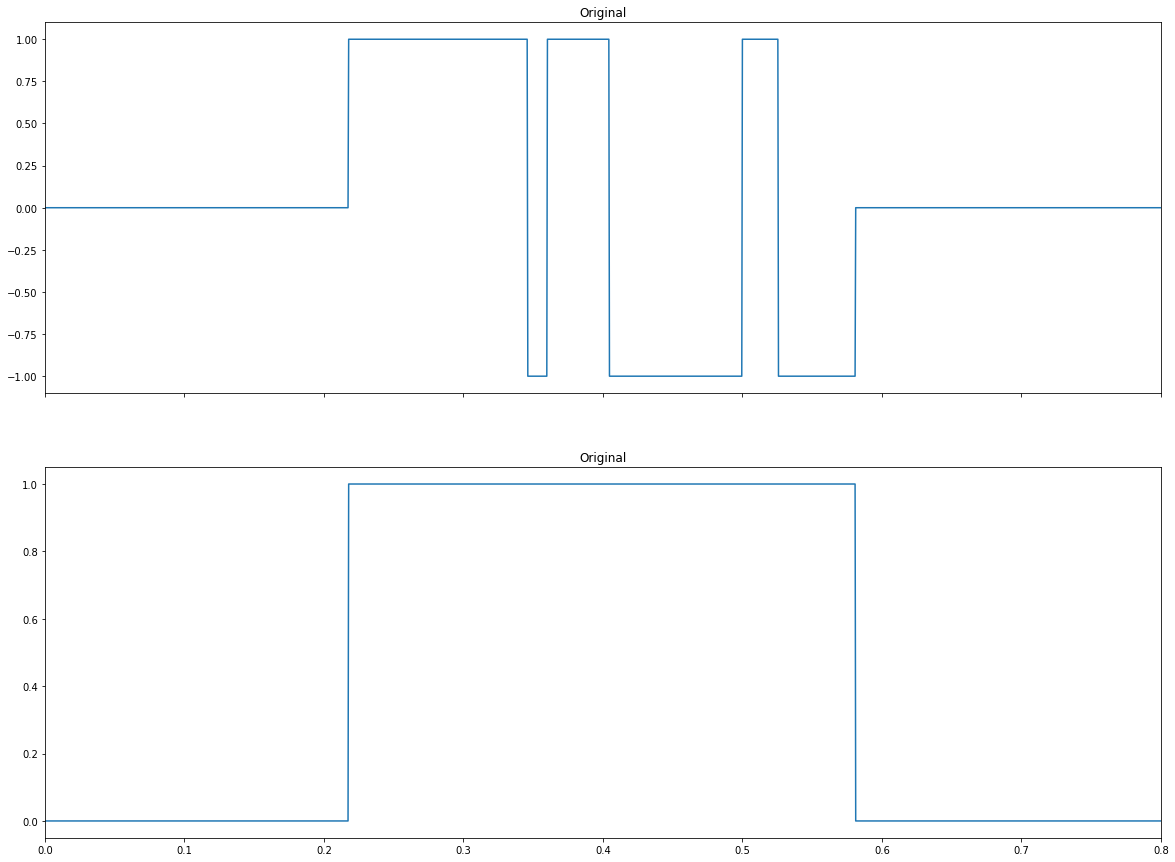

In [9]:
sample_envelope_slope_sign = envelope_slope_sign[2]
sample_signal_duration = signal_duration[2]
event_duration = len(sample_envelope_slope_sign) / samplerate_dec
timeline = np.linspace(0, event_duration, num=len(sample_envelope_slope_sign))

f, axes = plt.subplots(2, sharex=True, figsize=(20, 15))

axes[0].plot(timeline, sample_envelope_slope_sign)
axes[0].set_xlim([0, event_duration])
axes[0].set_title("Original")

axes[1].plot(timeline, sample_signal_duration)
axes[1].set_xlim([0, event_duration])
axes[1].set_title("Original")

f.show()

In [10]:
dur = [np.sum(event) / samplerate_dec for event in signal_duration]
zero_crossing = [
    np.count_nonzero(np.abs(np.diff(event))) for event in envelope_slope_sign
]
amplitude = [np.max(event) for event in events_abs]
calc_ratio = lambda ev, max_pos: np.trapz(ev[:max_pos], axis=0) / np.trapz(ev, axis=0)
ratio = [calc_ratio(event, np.argmax(event)) for event in events_envelope]
std = [np.std(event) for event in data_scaled]

In [11]:
ratio = []
for event in events_envelope:
    max_pos = np.argmax(event)
    ratio.append(np.trapz(event[:max_pos], axis=0) / np.trapz(event, axis=0))

In [12]:
X_data = np.array([dur, zero_crossing, amplitude, ratio, std]).transpose()
X_data

array([[0.42131519, 6.        , 0.5       , 0.55812695, 0.05447687],
       [0.37596372, 5.        , 0.31330587, 0.62925759, 0.03289615],
       [0.36326531, 7.        , 0.19709316, 0.57451924, 0.02304588],
       ...,
       [0.22086168, 3.        , 0.09766537, 0.58668405, 0.01624799],
       [0.2031746 , 3.        , 0.08045319, 0.59040862, 0.01315449],
       [0.62539683, 8.        , 0.24767681, 0.31811127, 0.03333723]])

In [13]:
X_data = (
    np.array(
        [
            X_data[:, 0] * 256,
            X_data[:, 1],
            X_data[:, 2] * 256,
            X_data[:, 3] * 256,
            X_data[:, 4] * 256,
        ]
    )
    .transpose()
    .astype(int)
)
X_data

array([[107,   6, 128, 142,  13],
       [ 96,   5,  80, 161,   8],
       [ 92,   7,  50, 147,   5],
       ...,
       [ 56,   3,  25, 150,   4],
       [ 52,   3,  20, 151,   3],
       [160,   8,  63,  81,   8]])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, labels, test_size=0.33, random_state=42
)

model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1)

# Se entrena el modelo
model.fit(X_train, y_train)

# Se prueba con la partición de optimización
y_pred = model.predict(X_test)

sc = balanced_accuracy_score(y_test, y_pred)
print(f"{sc:.3f} balanced accuracy\n")

colnames = ["Duracion", "Cruces", "Maximo", "Simetria", "Desvio"]
tree_rules = export_text(model, feature_names=colnames)
print(tree_rules)

0.684 balanced accuracy

|--- Maximo <= 50.50
|   |--- Maximo <= 39.50
|   |   |--- Simetria <= 64.50
|   |   |   |--- class: 1
|   |   |--- Simetria >  64.50
|   |   |   |--- class: 1
|   |--- Maximo >  39.50
|   |   |--- Simetria <= 95.50
|   |   |   |--- class: 0
|   |   |--- Simetria >  95.50
|   |   |   |--- class: 1
|--- Maximo >  50.50
|   |--- Simetria <= 127.50
|   |   |--- Cruces <= 4.50
|   |   |   |--- class: 0
|   |   |--- Cruces >  4.50
|   |   |   |--- class: 2
|   |--- Simetria >  127.50
|   |   |--- Simetria <= 214.50
|   |   |   |--- class: 2
|   |   |--- Simetria >  214.50
|   |   |   |--- class: 0



In [15]:
X_data = X_data[:, 1:-1]

X_train, X_test, y_train, y_test = train_test_split(
    X_data, labels, test_size=0.33, random_state=42
)

model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

sc = balanced_accuracy_score(y_test, y_pred)
print(f"{sc:.3f} balanced accuracy\n")

colnames = colnames[1:-1]
tree_rules = export_text(model, feature_names=colnames)
print(tree_rules)

0.684 balanced accuracy

|--- Maximo <= 50.50
|   |--- Maximo <= 39.50
|   |   |--- Simetria <= 64.50
|   |   |   |--- class: 1
|   |   |--- Simetria >  64.50
|   |   |   |--- class: 1
|   |--- Maximo >  39.50
|   |   |--- Simetria <= 95.50
|   |   |   |--- class: 0
|   |   |--- Simetria >  95.50
|   |   |   |--- class: 1
|--- Maximo >  50.50
|   |--- Simetria <= 127.50
|   |   |--- Cruces <= 4.50
|   |   |   |--- class: 0
|   |   |--- Cruces >  4.50
|   |   |   |--- class: 2
|   |--- Simetria >  127.50
|   |   |--- Simetria <= 214.50
|   |   |   |--- class: 2
|   |   |--- Simetria >  214.50
|   |   |   |--- class: 0



In [16]:
PORT = "/dev/ttyUSB0"
BAUD_RATE = 115200

serial_port = serial.Serial(PORT, BAUD_RATE, timeout=0.25)
serial_port.flushInput()

predictions_esp = []
for event in X_data:
    [serial_port.write(int(value).to_bytes(1, "little")) for value in event]
    byte = serial_port.read(1)
    result = int.from_bytes(byte, "little")
    predictions_esp.append(result)

serial_port.close()

In [20]:
predictions = model.predict(X_data)

print(f"Equal? {np.array_equal(predictions, predictions_esp)}")
print(f"Predictions sample: {predictions[:15].tolist()}")
print(f"Predictions ESP sample: {predictions_esp[:15]}")

Equal? True
Predictions sample: [2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1]
Predictions ESP sample: [2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1]
